In [17]:
import pandas as pd
import numpy as np
import pyclustertend 
import random
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing
from sklearn.datasets import make_classification
from sklearn.cluster import Birch
import matplotlib.pyplot as plt

### Pregunta 1

In [18]:
movies = pd.read_csv('movies.csv', encoding = "ISO-8859-1")
variables = movies.select_dtypes(include=np.number)

normalized_variables =(variables-variables.min())/(variables.max()-variables.min())
print(normalized_variables)

            id    budget   revenue   runtime  popularity   voteAvg  voteCount  \
0     0.000000  0.010526  0.001495  0.130667    0.001449  0.505747   0.067431   
1     0.000001  0.055263  0.004263  0.146667    0.000465  0.597701   0.007211   
2     0.000007  0.028947  0.272333  0.161333    0.008347  0.793103   0.539091   
3     0.000008  0.247368  0.330261  0.133333    0.011349  0.747126   0.517329   
4     0.000009  0.144737  0.237910  0.189333    0.004751  0.827586   0.716017   
...        ...       ...       ...       ...         ...       ...        ...   
9995  0.997637  0.000000  0.000000  0.133333    0.001081  0.632184   0.003475   
9996  0.997705  0.000000  0.000000  0.129333    0.042496  0.022989   0.000032   
9997  0.999737  0.000000  0.000000  0.149333    0.048943  0.551724   0.000942   
9998  0.999894  0.000000  0.000000  0.078667    0.000471  0.540230   0.000000   
9999  1.000000  0.000669  0.000089  0.000000    0.006930  0.390805   0.000065   

      genresAmount  product

### Pregunta 2

In [19]:
random.seed(123)
X_scale=sklearn.preprocessing.scale(normalized_variables)

pyclustertend.hopkins(normalized_variables, len(normalized_variables))

0.03133925898278195

El valor de hopkins es de 0.03, por lo que vale la pena hacer el agrupamiento.

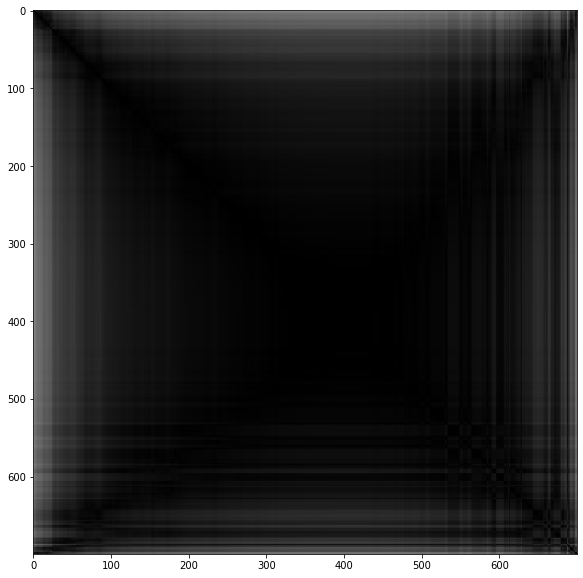

In [20]:
pyclustertend.vat(variables[:700])

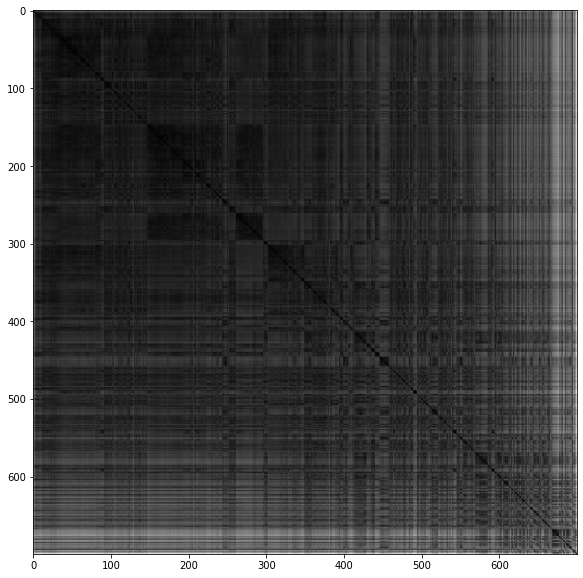

In [21]:
pyclustertend.vat(X_scale[:700])

### Pregunta 3

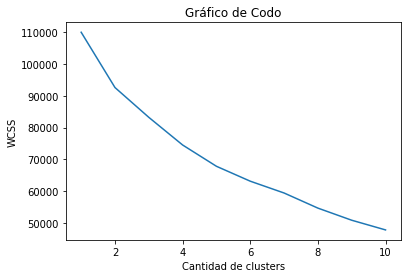

In [22]:
numeroClusters = range(1,11)

wcss = []
# Obtenemos 10 posibles clusters
for i in numeroClusters:
    # Se calcula la kmean con esa cantidad de clusters
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scale)
    # Obtenemos la inercia
    wcss.append(kmeans.inertia_)

# Graficando
plt.plot(numeroClusters, wcss)
plt.xlabel("Cantidad de clusters")
plt.ylabel("WCSS")
plt.title("Gráfico de Codo")
plt.show()

### Pregunta 4 - Metodo de BIRCH
Referencia de: https://www.freecodecamp.org/espanol/news/8-algoritmos-de-agrupacion-en-clusteres-en-el-aprendizaje-automatico-que-todos-los-cientificos-de-datos-deben-conocer/

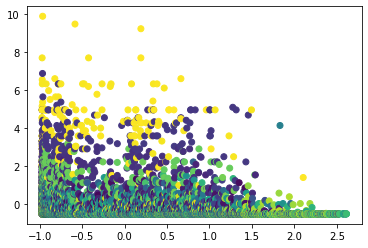

In [34]:
# Inicializar el modelo
birch_model = Birch(threshold=0.03, n_clusters=None)
birch_model.fit(X_scale)

# Obtenemos los puntos y los clusters
birch_result = birch_model.predict(X_scale)

# Graficar los clusters
plt.scatter(X_scale[:, 0], X_scale[:, 1], c = birch_result)
plt.show()